<div class="output_png output_subarea output_execute_result">
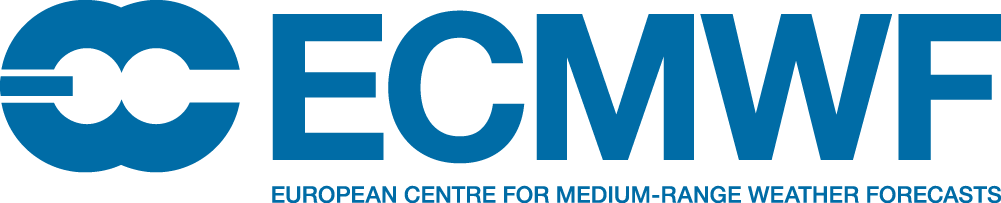
</div>

# Windsea: mean period of waves and direction

This notebook will provide you guidance how to explore ECMWF data to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-mwpww-mwd 


<div class="output_png output_subarea output_execute_result">
<center>
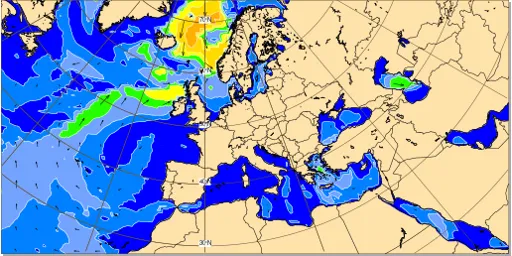
</div>

Some ECMWF real-time products are governed by the [ECMWF Standard Licence Agreement](https://www.ecmwf.int/sites/default/files/ECMWF_Standard_Licence.pdf) and are not free or open. Access to these products depends on your use case. To find out which licence applies to you, please visit: [Use cases and licence conditions page](https://www.ecmwf.int/en/forecasts/accessing-forecasts/licences-available).  

To find out how to obtain the access to the ECMWF forecast data please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 3 parameters :

* [Mean period of wind waves](https://codes.ecmwf.int/grib/param-db/140236)
* [Significant height of wind waves](https://codes.ecmwf.int/grib/param-db/140234)
* [Mean direction of wind waves](https://codes.ecmwf.int/grib/param-db/140235)

In this example, we will use: 
- [**ecmwf-api-client**](https://pypi.org/project/ecmwf-api-client/) to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below and run the next cell.
</div>

In [1]:
#!pip install ecmwf-api-client metview metview-python

In [1]:
import metview as mv
from ecmwfapi import *
import requests

In [2]:
parameters = "140234/140235/140236"
filename = 'medium-mwpww-mwd.grib'
filename

'medium-mwpww-mwd.grib'

In [ ]:
server = ECMWFService("mars")
server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": parameters,
    "step": "12",
    "stream": "wave",
    "time": "00",
    "type": "fc",
    "grid": "0.25/0.25"
    },
    filename)

Alternatevly we have prepared a small sample dataset to explore

In [5]:
url = f"https://get.ecmwf.int/repository/opencharts-sample-data/{filename}"
r = requests.get(url)
with open(filename, 'wb') as file:
    file.write(r.content)

## Reading and processing the data
Now we can use **ecmwf.data** to read the files.

In [3]:
data = mv.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [4]:
data.describe()

parameter,typeOfLevel,level,date,time,step,paramId,class,stream,type,experimentVersionNumber
mdww,meanSea,0,20241229,0,12,140235,od,wave,fc,0001
mpww,meanSea,0,20241229,0,12,140236,od,wave,fc,0001
shww,meanSea,0,20241229,0,12,140234,od,wave,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [5]:
data.describe('mpww')

shortName,mpww
name,Mean period of wind waves
paramId,140236
units,s
typeOfLevel,meanSea
level,0
date,20241229
time,0
step,12
class,od
stream,wave


We can use **ls()** function to list all the fields in the file we downloaded.

In [6]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,gridType
Message,,,,,,,,,
0,ecmf,shww,meanSea,0,20241229,0,12,fc,regular_ll
1,ecmf,mdww,meanSea,0,20241229,0,12,fc,regular_ll
2,ecmf,mpww,meanSea,0,20241229,0,12,fc,regular_ll


The grib file contains all the parameters, and we will use the **select()** function to filter what we need.  
Feel free to use **describe()** to inspect the other filtered fields.

In [7]:
shww = data.select(shortName= "shww")
mdww = data.select(shortName= "mdww")
mpww = data.select(shortName= "mpww")

We need to create a wind vector field for the visualisation, as well.

In [8]:
wave_vector = mv.grib_vectors(type='polar_field', intensity = shww, direction = mdww)

And finally, we can plot the data on the map. 

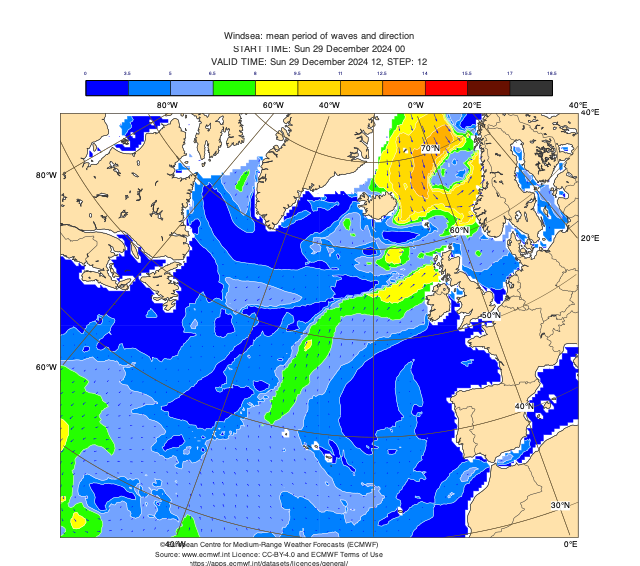

In [9]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="north_atlantic",
    subpage_clipping="on",
    coastlines=coast
)

#define styles
mpww_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_all_f0t18i1_5")

wave_arrows = mv.mwind(
    wind_thinning_factor=5, wind_arrow_colour="blue", wind_arrow_calm_below = 0.0
)

title = mv.mtext(
    text_lines = ["Windsea: mean period of waves and direction",
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=mpww'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=mpww'/>, STEP: <grib_info key='step' where='shortName=mpww' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, mpww, mpww_shade, wave_vector, wave_arrows, title, ecmwf_text)

To generate the png file you can run the following cell.

In [10]:
png = mv.png_output(
    output_name = "medium-mwpww-mwd",    # specify relative or full path
    output_title = "medium-mwpww-mwd",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, mpww, mpww_shade, wave_vector, wave_arrows, title, ecmwf_text)

Note that plot produced using this dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
The data used here is on 0.25x0.25 resolution, while high resolution data is 0.1x0.1 grid.